# ML_TreeBasedMethods_Classification

Credits:

- [2021 Python for Machine Learning & Data Science Masterclass by Jose Portilla Udemy](https://www.udemy.com/course/python-for-machine-learning-data-science-masterclass/)

*Inventors: Claude Shannon, Leo Breiman, Charles Stone*

<img src='images/TBM0.png' width='800'>


### **Terminology**
- *Root Node*: the topmost node of the tree.
- *Internal Nodes (Branches)*: nodes with a condition in it. They arrows pointing to the and away from them.
- *Leaf (terminal) Nodes*: the nodes with the output of a condition in the parent node.
- *Pruning*: 
- *Gini impurity*: is a mathematical measurement of how “pure” the information in a data set is. In regards to classification, we can think of this as a measurement of class uniformity.

    <img src='images/TBM2.png' width='800'>

 If the goal of a decision tree is to separate out classes as perfectly as possible, we can use gini impurity to decide on data split values. We want to minimize the gini impurity at leaf nodes.
Minimized impurity at leaf nodes means we are separating classes effectively.


There are 3 main tree based methods: Decision Tree, Random Forests and Boosted Trees. 

### 1. Decision Trees
Decision Tree Learning refers to the statistical modeling that uses a form of decision trees, where node splits are decided based on an information metric. 
- A decision tree is constructed from a training data set using Gini Impurity. The root node is the starts with the feature with the least Gini impurity value (the feature that has the ability to purify the data the best).
- By choosing the feature with the lowest resulting gini impurity in its leaf nodes, we are choosing the feature that best splits the data into “pure” classes.
- By using gini impurity as a measurement of the effectiveness of a node split, we can perform automatic feature selection by mandating an impurity threshold for an additional feature based split to occur. Hyperparameters for pruning:
    - Min gini impuroty decrease
    - Max tree depth.

Decision Tree for a single (Binary) Catagorical feature:
<img src='images/TBM3.png' width='1000'>

Decision Tree for a single Continuous feature:
<img src='images/TBM4.png' width='1000'>

Decision Tree for a single (Multi) Catagorical feature:
<img src='images/TBM5.png' width='1000'>

### 2. Random Forests



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data

We will work with the "Palmer Penguins" dataset, as it is simple enough to help us fully understand how changing hyperparameters can change classification results.

<img src="images/penguin.jpg" align='right' style="max-width:200px">

Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network. [source](doi:10.1371/journal.pone.0090081)

* penguins_size.csv: Simplified data from original penguin data sets. Contains variables:

    * species: penguin species (Chinstrap, Adélie, or Gentoo)
    * culmen_length_mm: culmen length (mm)
    * culmen_depth_mm: culmen depth (mm)
    * flipper_length_mm: flipper length (mm)
    * body_mass_g: body mass (g)
    * island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
    * sex: penguin sex

* (Not used) penguins_lter.csv: Original combined data for 3 penguin species  

Note: The culmen is "the upper ridge of a bird's beak" 

Our goal is to create a model that can help predict a species of a penguin based on physical attributes, then we can use that model to help researchers classify penguins in the field, instead of needing an experienced biologist.

In [49]:
df = pd.read_csv('data/penguins_size.csv')
df.head(5)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## Feature Engineering I

In [50]:
df['species'].unique() # To be predicted (classification)

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [51]:
df.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

- We have some data mising!

In [52]:
df = df[df['sex'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


- Simply dropping the rows with null for 'sex' also cleaned up the nulls for other features as well!

In [53]:
df['island'].unique(), df['sex'].unique()

(array(['Torgersen', 'Biscoe', 'Dream'], dtype=object),
 array(['MALE', 'FEMALE', '.'], dtype=object))

In [54]:
df[df['sex']=='.'] # bad information

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


- We can impute the 'sex' of this penguin using a feature most correlated with 'sex' feature!

In [58]:
df_corr = df.drop(index=336)
df_corr['sex'] = df['sex'].map({'MALE':0,'FEMALE':1}).drop(index=336)

In [68]:
df_corr.corr()['sex'].abs().sort_values(ascending=False)[1:]

body_mass_g          0.424987
culmen_depth_mm      0.372673
culmen_length_mm     0.344078
flipper_length_mm    0.255169
Name: sex, dtype: float64

- So clearly, we can impute the missing 'sex' value using 'body_mass_g' feature of that particular specie which is 'Gentoo'!

In [77]:
df[df['species']=='Gentoo'].groupby('sex').describe().T

sex                           .       FEMALE         MALE
culmen_length_mm  count     1.0    58.000000    61.000000
                  mean     44.5    45.563793    49.473770
                  std       NaN     2.051247     2.720594
                  min      44.5    40.900000    44.400000
                  25%      44.5    43.850000    48.100000
                  50%      44.5    45.500000    49.500000
                  75%      44.5    46.875000    50.500000
                  max      44.5    50.500000    59.600000
culmen_depth_mm   count     1.0    58.000000    61.000000
                  mean     15.7    14.237931    15.718033
                  std       NaN     0.540249     0.741060
                  min      15.7    13.100000    14.100000
                  25%      15.7    13.800000    15.200000
                  50%      15.7    14.250000    15.700000
                  75%      15.7    14.600000    16.100000
                  max      15.7    15.500000    17.300000
flipper_length_mm count     1.0    58.000000    61.000000
                  mean    217.0   212.706897   221.540984
                  std       NaN     3.897856     5.673252
                  min     217.0   203.000000   208.000000
                  25%     217.0   210.000000   218.000000
                  50%     217.0   212.000000   221.000000
                  75%     217.0   215.000000   225.000000
                  max     217.0   222.000000   231.000000
body_mass_g       count     1.0    58.000000    61.000000
                  mean   4875.0  4679.741379  5484.836066
                  std       NaN   281.578294   313.158596
                  min    4875.0  3950.000000  4750.000000
                  25%    4875.0  4462.500000  5300.000000
                  50%    4875.0  4700.000000  5500.000000
                  75%    4875.0  4875.000000  5700.000000
                  max    4875.0  5200.000000  6300.000000

- culmen_length_mm: close to FEMALE avg --> F
- culmen_depth_mm: close to MALE (max for FEAMLE is 15.5) --> M
- flipper_length_mm: hard to tell!
- body_mass_g: close to FEMALE -->F
- So we chose FEMALE

In [78]:
# Using the at() method
df.at[336,'sex'] = 'FEMALE'
df.loc[336]

species              Gentoo
island               Biscoe
culmen_length_mm       44.5
culmen_depth_mm        15.7
flipper_length_mm       217
body_mass_g            4875
sex                  FEMALE
Name: 336, dtype: object

## EDA

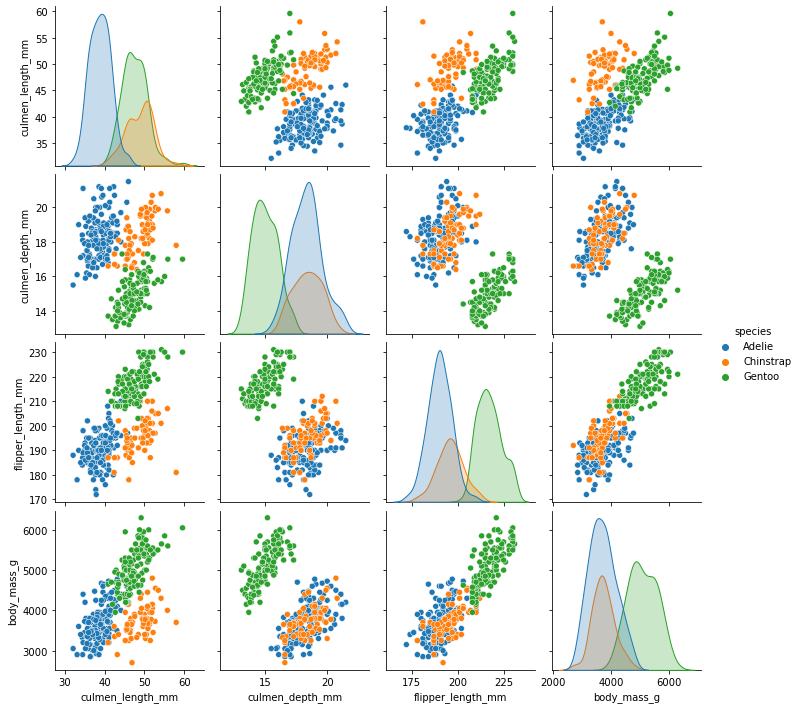

In [81]:
sns.pairplot(data=df,hue='species');

- Well separated!

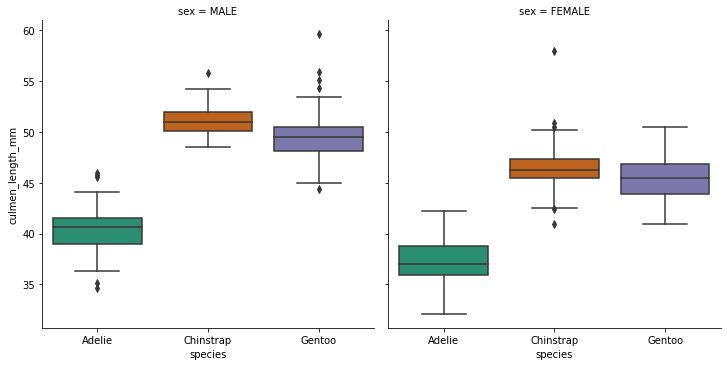

In [82]:
sns.catplot(x='species',y='culmen_length_mm',data=df,kind='box',col='sex',palette='Dark2');

## Feature Engineering II

In [85]:
X = pd.get_dummies(df.drop('species',axis=1),drop_first=True)
y = df['species']

## 1. Decision Tree

For Decision Tree, a tree node is going to directly compare on a single feature. Thus, scaling is not necessary as it is never going to use multiple feature at the same time.

              precision    recall  f1-score   support

      Adelie       0.95      0.98      0.96        41
   Chinstrap       0.95      0.91      0.93        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.97       101
   macro avg       0.97      0.96      0.97       101
weighted avg       0.97      0.97      0.97       101



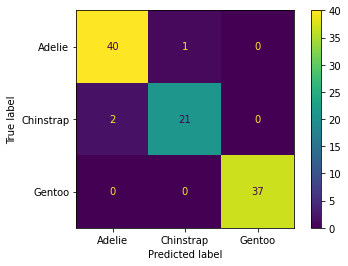

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.3, random_state=101)

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
base_pred = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,base_pred))

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model,X_test,y_test);

- One of the most important advantages of using a Decision Tree model is that its very interpretable.

### Feature Importances

In [106]:
# relative importance of each feature in its decesion making
pd.DataFrame(index=X.columns,data=model.feature_importances_,
             columns=['Feature Imporatnce'])['Feature Imporatnce']\
            .sort_values(ascending=False)

flipper_length_mm    0.531201
culmen_length_mm     0.337546
island_Dream         0.068185
culmen_depth_mm      0.063067
sex_MALE             0.000000
island_Torgersen     0.000000
body_mass_g          0.000000
Name: Feature Imporatnce, dtype: float64

- So the most important feature for this particular decision tree was 'flipper_length_mm'.
- The features 'sex_MALE','island_Torgersen' and 'body_mass_g' are not even considered! This is due to the way the tree was contructed with the default hyperparameters.
- So we need to push the decision tree to consider all the features!

### Let's visualize the Decision Tree
[Online Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)

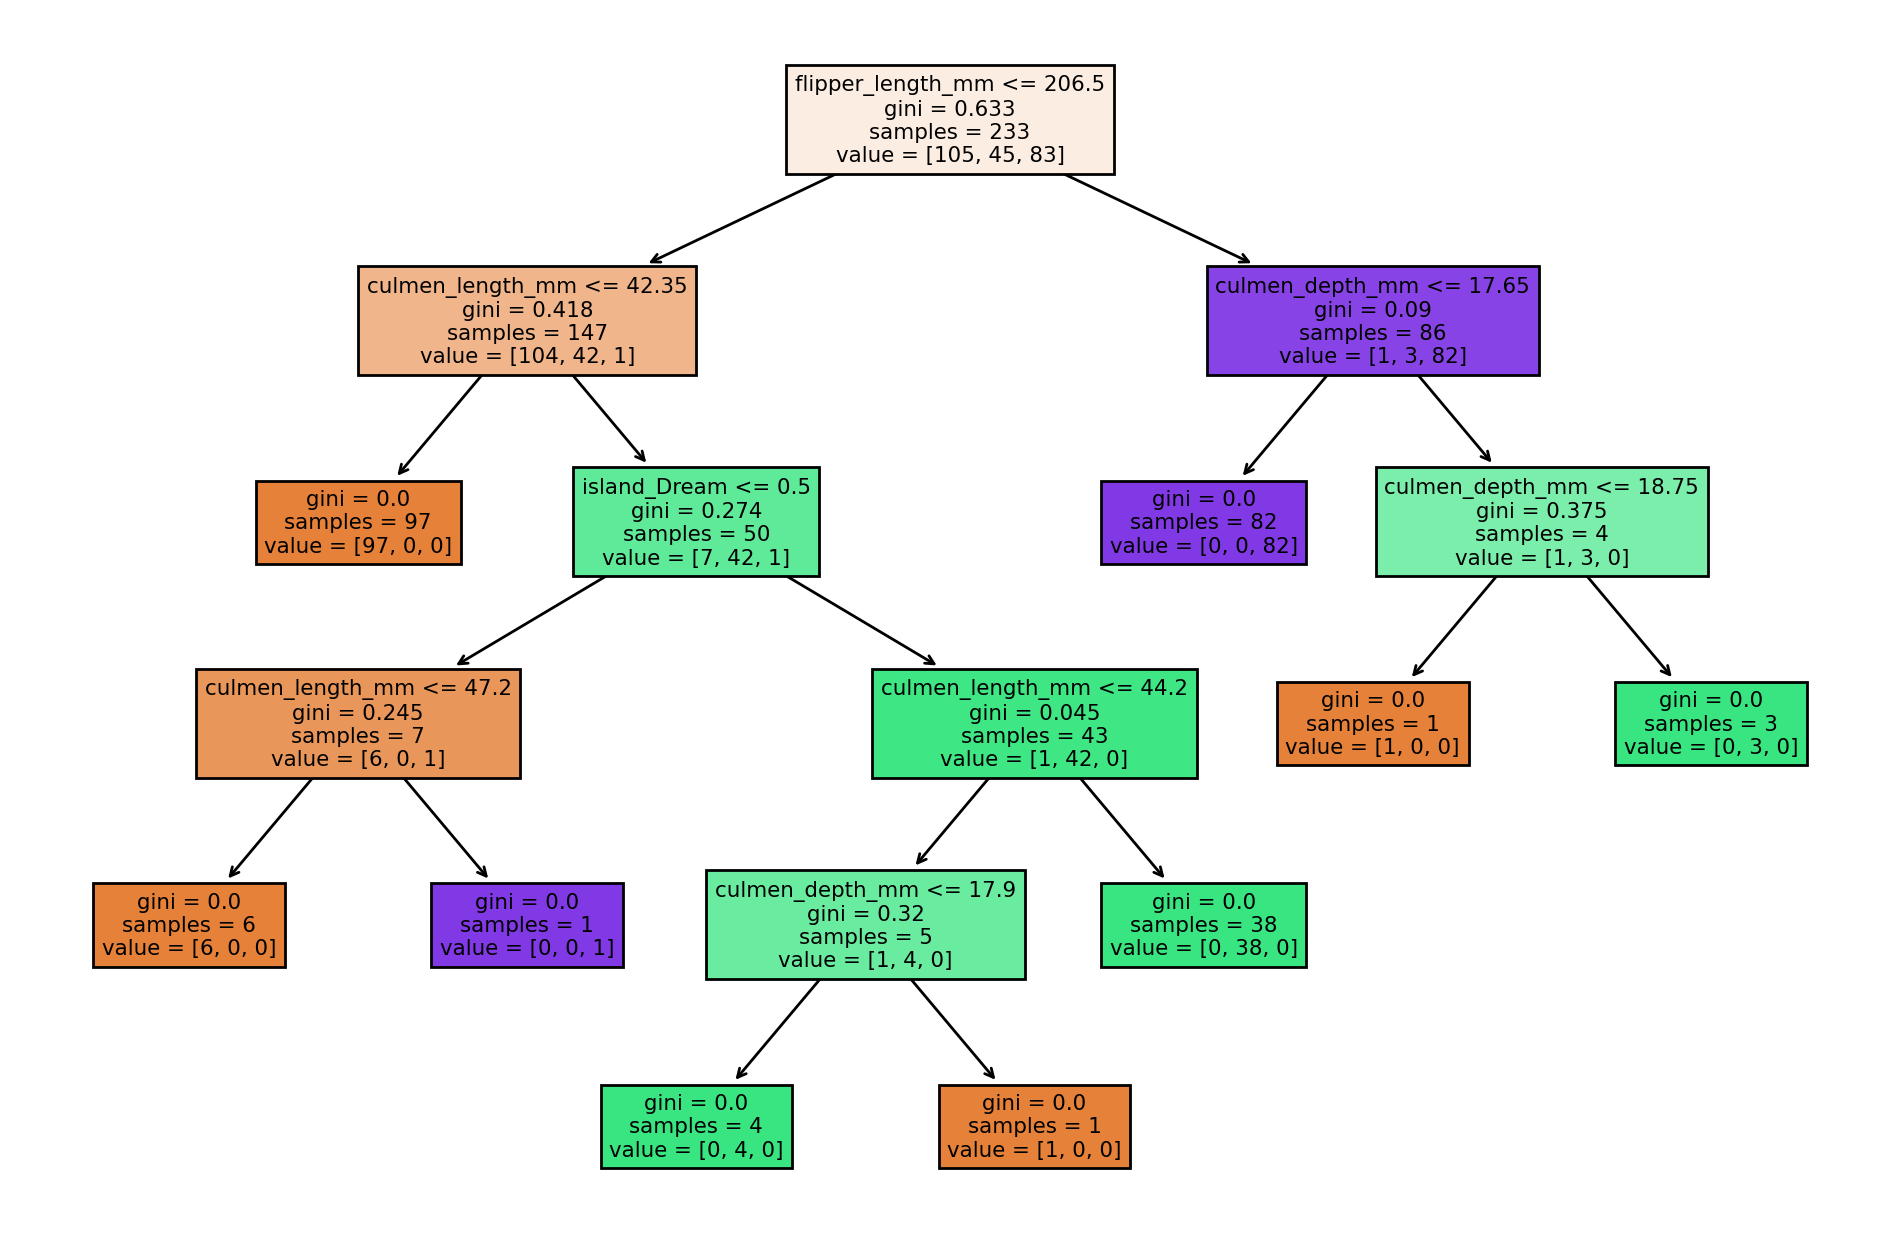

In [114]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12,8),dpi=200)
plot_tree(model,feature_names=X.columns,filled=True);

- Note that the Root Node is indeed the 'flipper_length_mm' feature which is the most important feature (with a gini impurity = 0.63) for this particular Decision Tree.

In [119]:
def report_model(model):
    model_preds = model.predict(X_test)
    
    print(classification_report(y_test,model_preds))
    print('\n')
    
    print(pd.DataFrame(index=X.columns,data=model.feature_importances_,
             columns=['Feature Imporatnce'])['Feature Imporatnce']\
            .sort_values(ascending=False))
    print('\n')

    plt.figure(figsize=(12,8),dpi=200)
    plot_tree(model,feature_names=X.columns,filled=True);

### Hyperparameter testing
- max depth, max leaf nodes and gini to entropy criteria
- - After limiting the max possible depth, we see that some leaf nodes have non-zero gini impurity!

              precision    recall  f1-score   support

      Adelie       0.97      0.88      0.92        41
   Chinstrap       0.83      0.87      0.85        23
      Gentoo       0.93      1.00      0.96        37

    accuracy                           0.92       101
   macro avg       0.91      0.92      0.91       101
weighted avg       0.92      0.92      0.92       101



flipper_length_mm    0.62149
culmen_length_mm     0.37851
sex_MALE             0.00000
island_Torgersen     0.00000
island_Dream         0.00000
body_mass_g          0.00000
culmen_depth_mm      0.00000
Name: Feature Imporatnce, dtype: float64




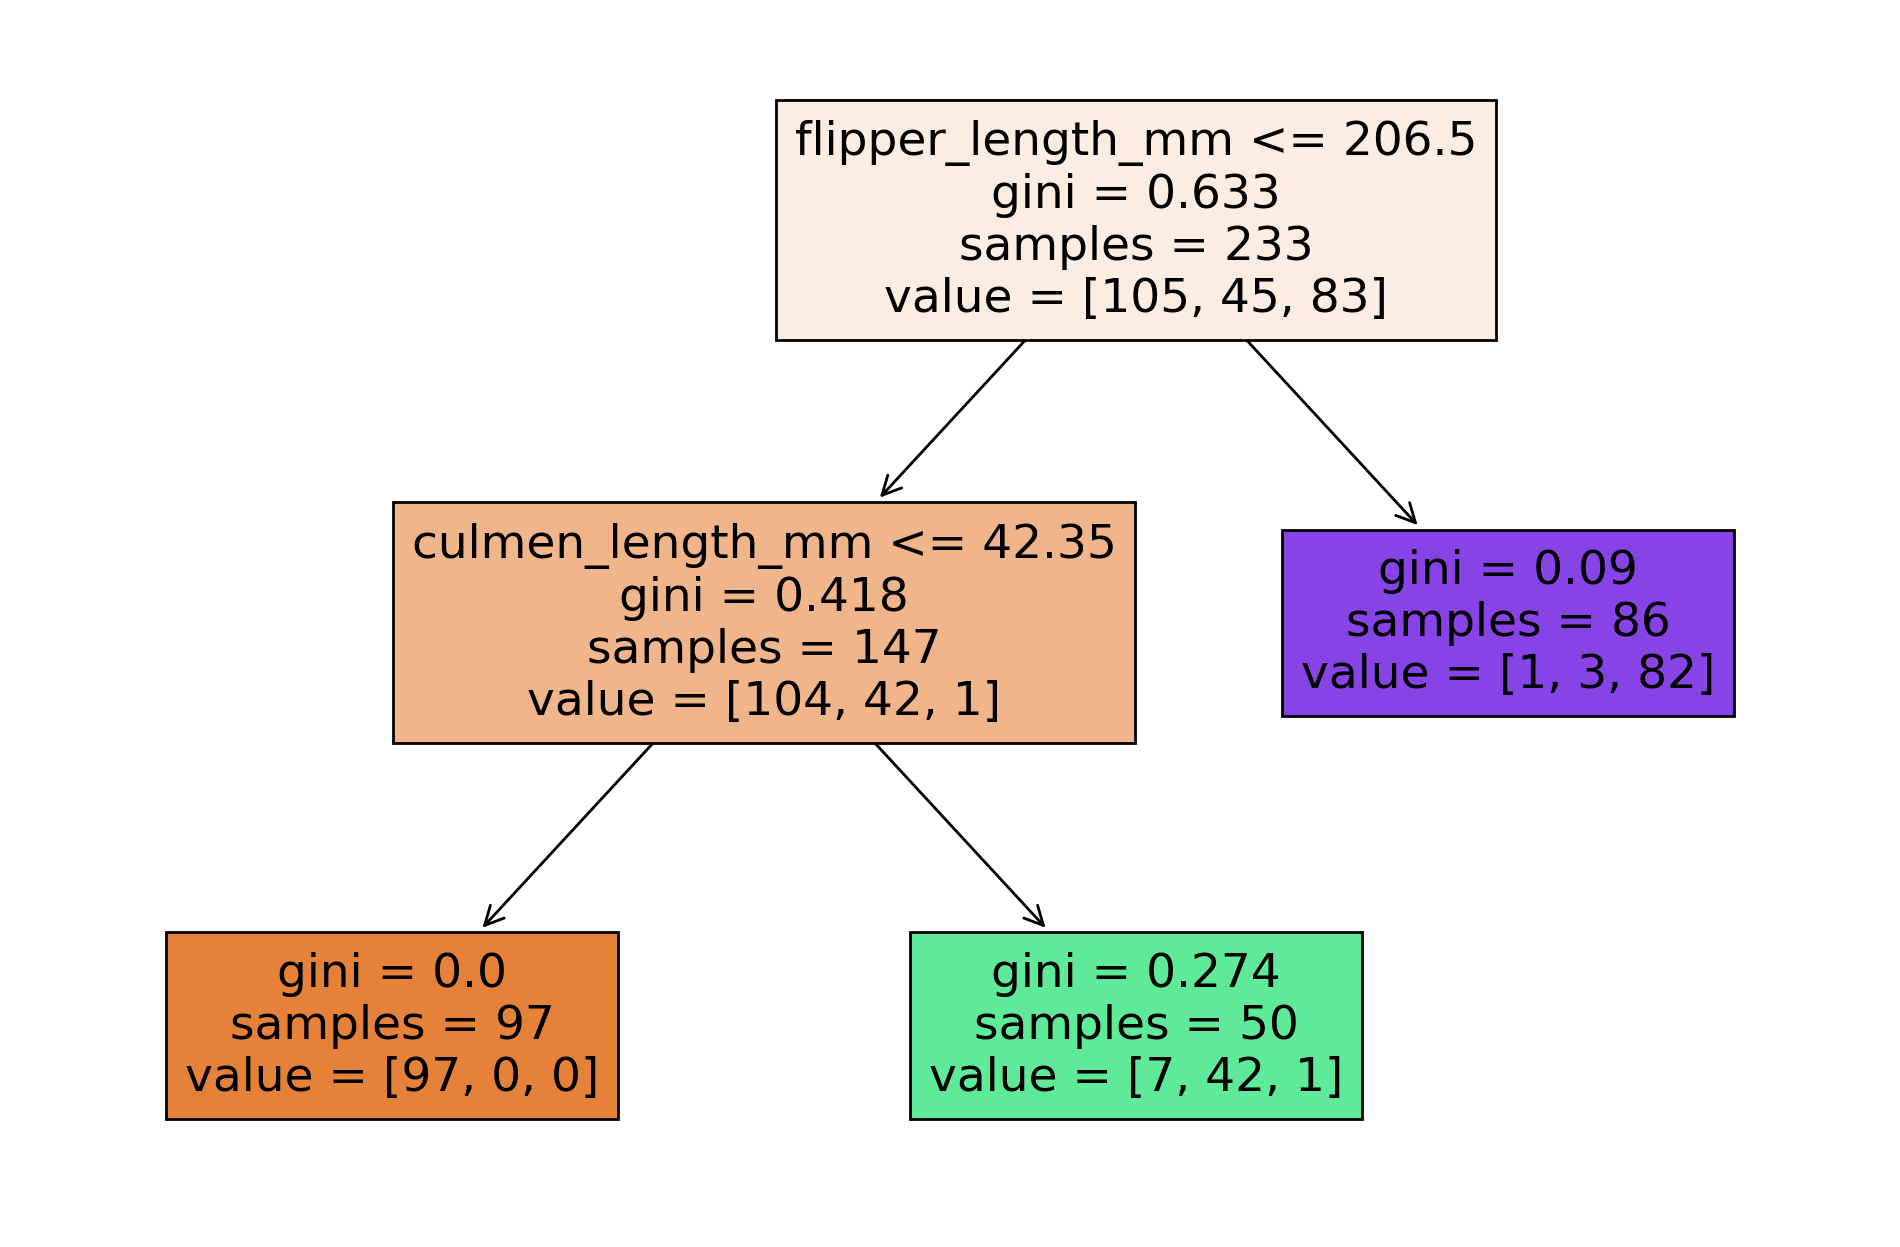

In [126]:
# max leaf nodes
pruned_tree = DecisionTreeClassifier(max_leaf_nodes=3)
pruned_tree.fit(X_train,y_train)
report_model(pruned_tree)

              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        41
   Chinstrap       1.00      0.96      0.98        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.99       101
   macro avg       0.99      0.99      0.99       101
weighted avg       0.99      0.99      0.99       101



flipper_length_mm    0.539691
culmen_length_mm     0.300350
island_Dream         0.071405
culmen_depth_mm      0.066476
sex_MALE             0.011796
body_mass_g          0.010281
island_Torgersen     0.000000
Name: Feature Imporatnce, dtype: float64




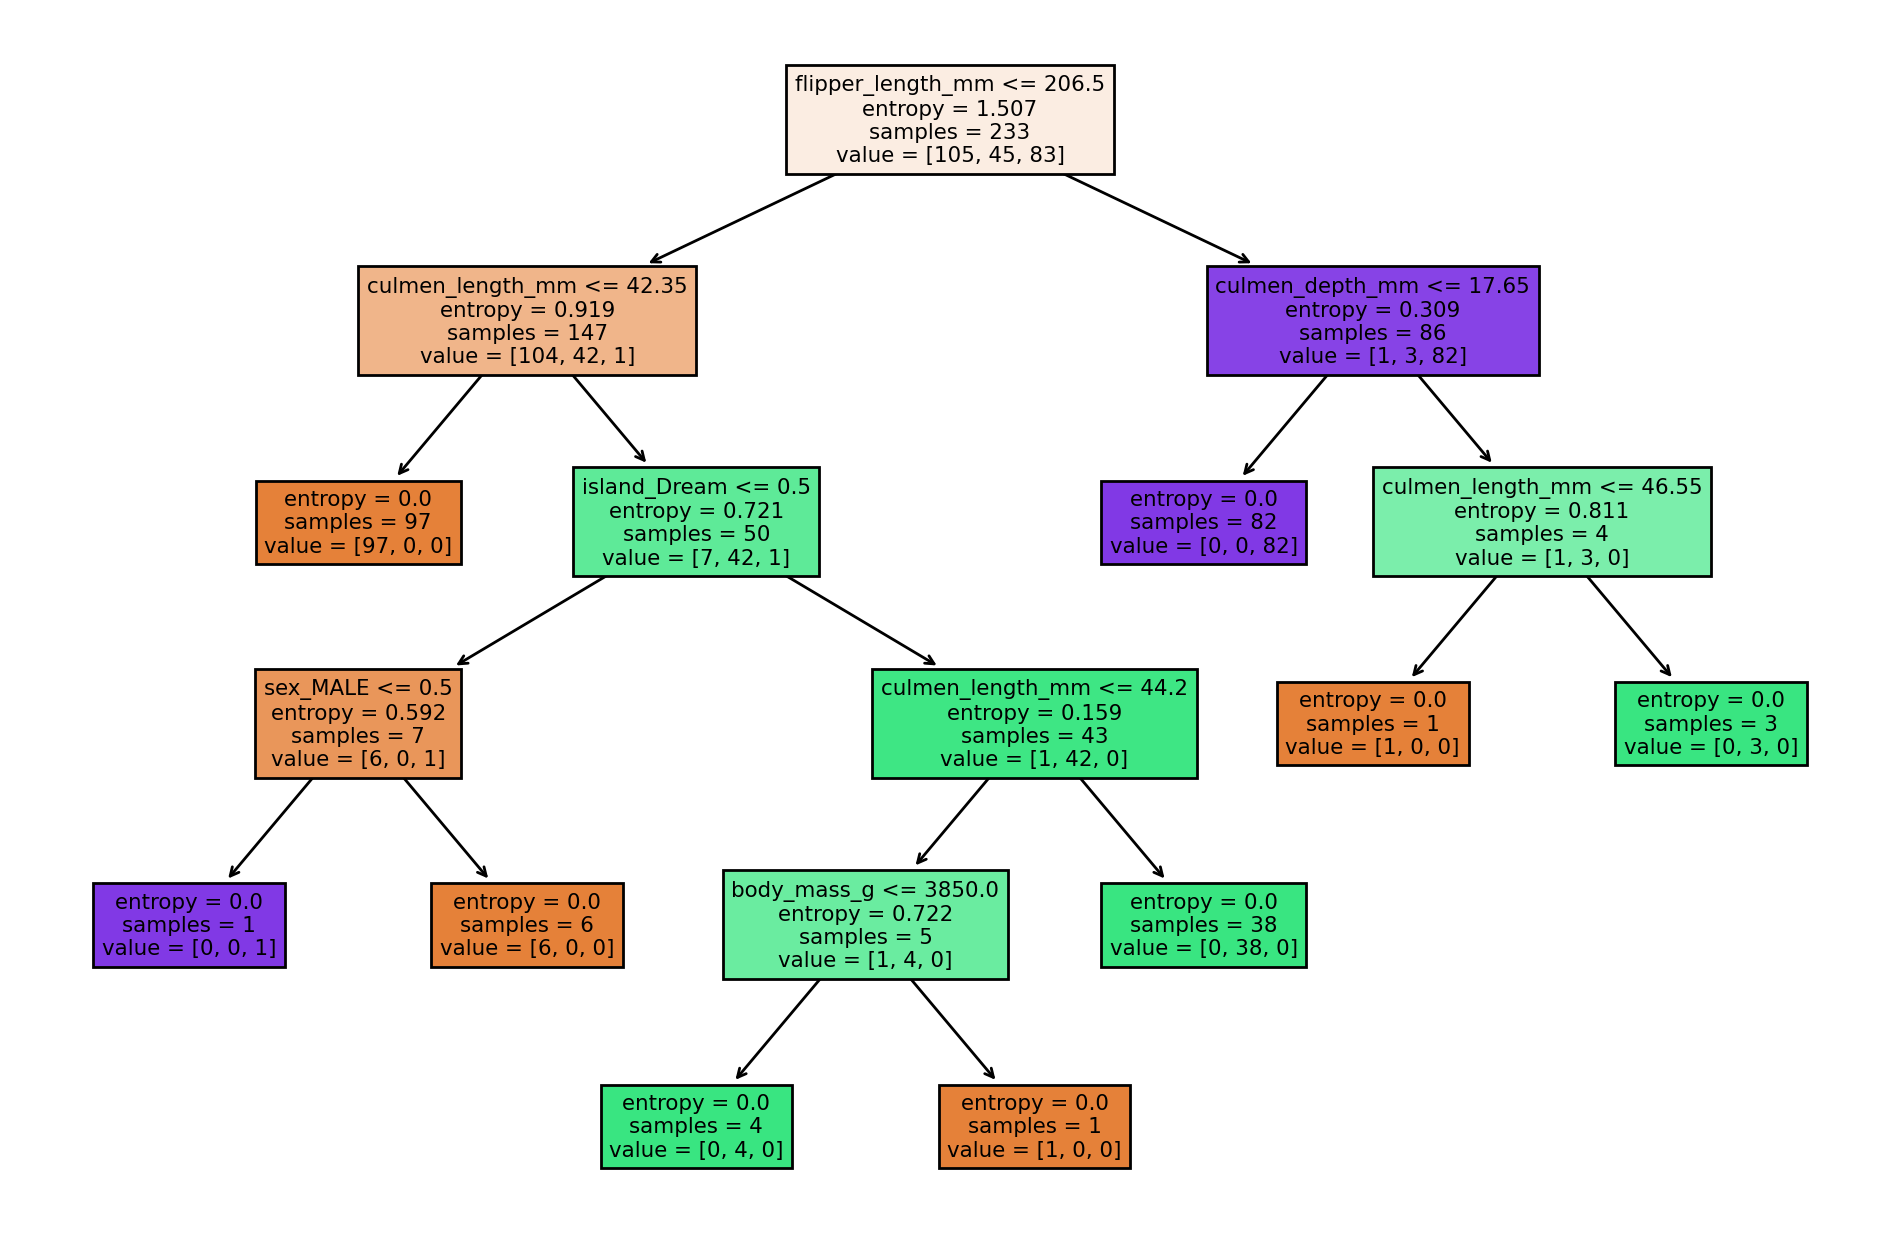

In [127]:
# entropy (information gain): changing the mathematical
# criteria of split from gini to entropy
pruned_tree = DecisionTreeClassifier(criterion='entropy')
pruned_tree.fit(X_train,y_train)
report_model(pruned_tree)